In [1]:
import os
import dask
import json
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)

In [21]:
comps = {'atm':'cam2','ocn':'pop','lnd':'clm2','ice':'cice'}
cases = {
    'lres.spinup':'spinup_pd_maxcores_f09_g16', # 200-300 => 2000-2100
    'lres.sai20':'lres_b.e10.B2000_CAM5.f09_g16.feedforward.001',
    'lres.sai':'lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001',
    'mres.cnt':'rcp8.5_co2_f05_t12', # 2000-2100
    'mres.sai':'mres_b.e10.B2000_CAM5.f05_t12.001', # 2045-2100
    'hres.ref.1':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001',
    'hres.ref.2':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002',
    'hres.ref.3':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003',
    'hres.ref.4':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.004',
    'hres.ref.5':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005',
    'hres.ref.6':'hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001', # additional run with 6hrly 3D output
    'hres.cnt.1':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001',
    'hres.cnt.2':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.002',
    'hres.cnt.3':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.003',
    'hres.cnt.4':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.004',
    'hres.cnt.5':'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.005',
    'hres.cnt.6':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12_without_SAI.001', # additional run with 6hrly 3D output
    'hres.sai.1':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001',
    'hres.sai.2':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.002',
    'hres.sai.3':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.003',
    'hres.sai.4':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.004',
    'hres.sai.5':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.005',
    'hres.sai.6':'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.006', # additional run with 6hrly 3D output
}

def get_casedir(tag):
    '''returns full path to the case directory given a case tag'''
    if tag not in cases:
        raise KeyError(f'tag ({tag}) not found in {cases.keys()}')
    grid = {'lres':'f09_g16', 'mres':'f05_t12', 'hres':'f02_t12'}[tag.split('.')[0]]
    isInNWO = (tag.split('.')[1] in ['sai','sai20']) or (tag in ['hres.ref.6','hres.cnt.6'])
    root = ('/projects/0/nwo2021025/archive' if isInNWO else
            f'/projects/0/prace_imau/prace_2013081679/cesm1_0_4/{grid}')
    addOUTPUT = (not isInNWO) and (tag != 'mres.cnt')
    casedir = f'{root}/{cases[tag]}' + ('/OUTPUT' if addOUTPUT else '')
    return casedir


def print_compstream(tag):
    '''returns available file streams for each model component given a case tag'''
    casedir = get_casedir(tag)
    ncFiles = sorted([file for dirs in os.walk(top=casedir) for file in dirs[2] if file.endswith('.nc')])
    for tag,comp in comps.items():
        compfiles = [file for file in ncFiles if comp in file.split('.')]
        compids = [file.split('.').index(comp) for file in compfiles]
        comp_available_streams = np.sort(np.unique([file.split('.')[id+1] for file,id in zip(compfiles,compids)]))
        print(f"{tag}: {comp_available_streams}", end=", ")
    print()


def select_compstream(tag, comp, stream):
    '''return all files for a given model component comp and file stream'''
    casedir = get_casedir(tag)
    ncFiles = sorted([file for dirs in os.walk(top=casedir) for file in dirs[2] if file.endswith('.nc')])
    compstreamfiles = [file for file in ncFiles if (comps[comp] in file.split('.')) and (stream in file.split('.'))]
    return np.sort([f'{casedir}/{comp}/hist/{file}' for file in compstreamfiles])
    

In [13]:
cases.keys()

dict_keys(['lres.spinup', 'lres.sai20', 'lres.sai', 'mres.cnt', 'mres.sai', 'hres.ref.1', 'hres.ref.2', 'hres.ref.3', 'hres.ref.4', 'hres.ref.5', 'hres.ref.6', 'hres.cnt.1', 'hres.cnt.2', 'hres.cnt.3', 'hres.cnt.4', 'hres.cnt.5', 'hres.cnt.6', 'hres.sai.1', 'hres.sai.2', 'hres.sai.3', 'hres.sai.4', 'hres.sai.5', 'hres.sai.6'])

In [23]:
print_compstream('hres.sai.1')

atm: ['h0' 'h1' 'h2' 'h3' 'h4' 'h5' 'i' 'r' 'rs'], ocn: ['h' 'hm' 'r'], lnd: ['h0' 'r' 'rh0'], ice: ['h' 'r'], 


In [21]:
sai = open_mfdataset(select_compstream('hres.sai.6', 'cam2', 'h0'))

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12_2093-11.006.cam2.h0.2092-12_2093-11.json


In [22]:
cnt = open_mfdataset(select_compstream('hres.cnt.6', 'cam2', 'h0'))

Writing combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12_2097-12_without_SAI.001.cam2.h0.2092-12_2097-12.json


In [23]:
ref = open_mfdataset(select_compstream('hres.ref.6', 'cam2', 'h0'))

Writing combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_2003-11_without_SAI.001.cam2.h0.2002-12_2003-11.json


Text(0.5, 1.0, 'CNT-REF')

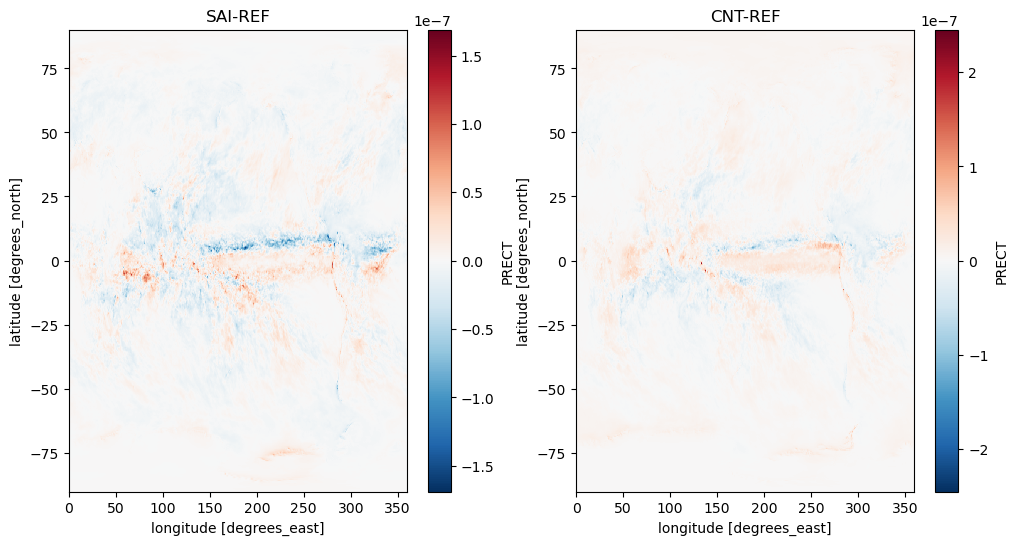

In [38]:
var = 'PRECT'
fig, ax = plt.subplots(1,2, figsize=(12,6))
(sai[var].mean('time')-ref[var].mean('time')).plot(ax=ax[0])
ax[0].set_title('SAI-REF')
(cnt[var].mean('time')-ref[var].mean('time')).plot(ax=ax[1])
ax[1].set_title('CNT-REF')

Text(0.5, 1.0, 'CNT-REF')

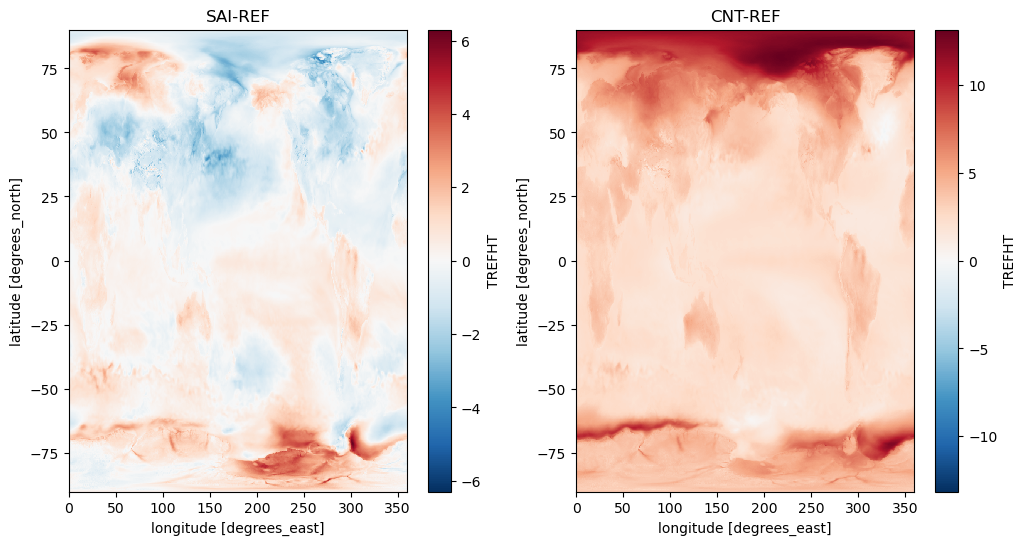

In [39]:
var = 'TREFHT'
fig, ax = plt.subplots(1,2, figsize=(12,6))
(sai[var].mean('time')-ref[var].mean('time')).plot(ax=ax[0])
ax[0].set_title('SAI-REF')
(cnt[var].mean('time')-ref[var].mean('time')).plot(ax=ax[1])
ax[1].set_title('CNT-REF')

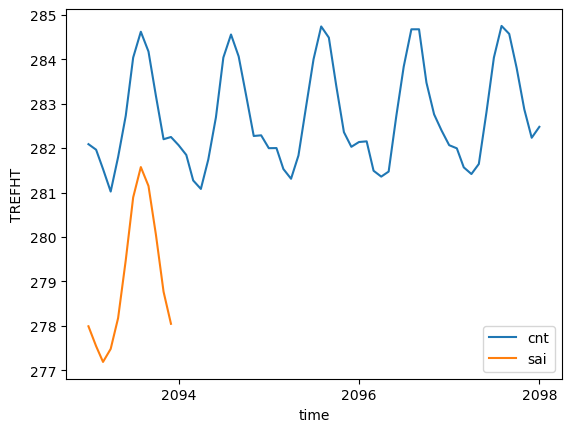

In [46]:
#ref.TREFHT.mean(('lat','lon')).plot(label='ref')
cnt.TREFHT.mean(('lat','lon')).plot(label='cnt')
sai.TREFHT.mean(('lat','lon')).plot(label='sai')
plt.legend()